In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import random
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import mean_squared_error
import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as sm
from sklearn.model_selection import KFold
from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn import metrics

In [26]:
gameTable = pd.read_csv('C://Users//Michael//Desktop//Springboard//Capstone1//dataCleaning//cleanedData//cleanedGameData.csv')
dvoaTable = pd.read_csv('C://Users//Michael//Desktop//Springboard//Capstone1//dataCleaning//cleanedData//cleanedDvoaData.csv', encoding='windows-1252')
pffTable = pd.read_csv('C://Users//Michael//Desktop//Springboard//Capstone1//dataCleaning//cleanedData//cleanedPffData.csv')

In [27]:
# First, turn date cols into dt objects
gameTable['date'] = pd.to_datetime(gameTable['date'])
pffTable['date'] = pd.to_datetime(pffTable['date'])

In [28]:
# Create a table of running averages for pff grades and game scores. Use previous 7-game averages for a team's variables
rollAvgPff = pffTable.set_index('date')
varDict = {'pf':'avgPf','pa':'avgPa','overall':'avgOvr','off':'avgOff','pass':'avgPass','pblk':'avgPblk','recv':'avgRecv',
           'run':'avgRun','rblk':'avgRblk','def':'avgDef','rdef':'avgRdef','tack':'avgTack','prsh':'avgPrsh','cov':'avgCov'}

for key, val in varDict.items():
    rollAvgPff[val] = rollAvgPff.groupby('team')[key].apply(lambda x: x.shift(1).rolling(window=7).mean())

rollAvgPff = rollAvgPff.fillna(method='bfill')
rollAvgPff = rollAvgPff.reset_index()

In [29]:
# Need to make new rollingAvgPff tables that have all dates covered... Dates in pff table are off by one or two days
# Strategy is to create new df's that have all dates, then join the normal pff table to each of them by date,
# then merge all the tables together. All dates will be in the final table
pffB1 = rollAvgPff.copy()
pffB1['date'] = pffB1['date'] - datetime.timedelta(days=1)
pffB2 = rollAvgPff.copy()
pffB2['date'] = pffB2['date'] - datetime.timedelta(days=2)
pffF1 = rollAvgPff.copy()
pffF1['date'] = pffF1['date'] + datetime.timedelta(days=1)
pffF2 = rollAvgPff.copy()
pffF2['date'] = pffF2['date'] + datetime.timedelta(days=2)

In [30]:
# Now join pffTable to each new df
t0 = pd.merge(gameTable,rollAvgPff,how='inner',left_on=['date','awayTeam'], right_on=['date','team'])
t1 = pd.merge(gameTable,pffB1,how='inner',left_on=['date','awayTeam'], right_on=['date','team'])
t2 = pd.merge(gameTable,pffB2,how='inner',left_on=['date','awayTeam'], right_on=['date','team'])
t3 = pd.merge(gameTable,pffF1,how='inner',left_on=['date','awayTeam'], right_on=['date','team'])
t4 = pd.merge(gameTable,pffF2,how='inner',left_on=['date','awayTeam'], right_on=['date','team'])
t5 = pd.merge(gameTable,rollAvgPff,how='inner',left_on=['date','homeTeam'], right_on=['date','team'])
t6 = pd.merge(gameTable,pffB1,how='inner',left_on=['date','homeTeam'], right_on=['date','team'])
t7 = pd.merge(gameTable,pffB2,how='inner',left_on=['date','homeTeam'], right_on=['date','team'])
t8 = pd.merge(gameTable,pffF1,how='inner',left_on=['date','homeTeam'], right_on=['date','team'])
t9 = pd.merge(gameTable,pffF2,how='inner',left_on=['date','homeTeam'], right_on=['date','team'])

In [31]:
awayTable = t0.append([t1,t2,t3,t4],ignore_index=True)
homeTable = t5.append([t6,t7,t8,t9],ignore_index=True)

In [32]:
awayTable['homeAway'] = 'away'
homeTable['homeAway'] = 'home'

In [33]:
awayTable.columns

Index(['gameId', 'date', 'awayTeam', 'awayScore', 'homeTeam', 'homeScore',
       'totalScore', 'overUnder', 'result', 'stadium', 'roof', 'surface',
       'vegasLine', 'referee', 'umpire', 'headLinesman', 'lineJudge',
       'backJudge', 'sideJudge', 'fieldJudge', 'season', 'week', 'team', 'opp',
       'time', 'w', 'pf', 'pa', 'overall', 'off', 'pass', 'pblk', 'recv',
       'run', 'rblk', 'def', 'rdef', 'tack', 'prsh', 'cov', 'spec', 'lateGame',
       'year', 'avgCov', 'avgPrsh', 'avgPass', 'avgOvr', 'avgDef', 'avgRdef',
       'avgRun', 'avgPblk', 'avgOff', 'avgRblk', 'avgRecv', 'avgPa', 'avgTack',
       'avgPf', 'homeAway'],
      dtype='object')

In [34]:
awayTable = awayTable[['gameId', 'date','season', 'week','team','homeAway',
       'stadium', 'roof', 'surface', 'avgPf', 'avgPa', 'avgOvr', 'avgOff',
       'avgPass', 'avgPblk', 'avgRecv', 'avgRun', 'avgRblk', 'avgDef', 'avgRdef',
       'avgPrsh', 'avgCov','pf','pa','totalScore', 'overUnder', 'result']]
homeTable = homeTable[['gameId', 'date','season', 'week','team','homeAway',
       'stadium', 'roof', 'surface', 'avgPf', 'avgPa', 'avgOvr', 'avgOff',
       'avgPass', 'avgPblk', 'avgRecv', 'avgRun', 'avgRblk', 'avgDef', 'avgRdef',
       'avgPrsh', 'avgCov','pf','pa','totalScore', 'overUnder', 'result']]

In [35]:
awayTable.head()

,gameId,date,season,week,team,homeAway,stadium,roof,surface,avgPf,...,avgRblk,avgDef,avgRdef,avgPrsh,avgCov,pf,pa,totalScore,overUnder,result
0,201811110kan,2018-11-11,2018,10,Arizona Cardinals,away,Arrowhead Stadium,outdoors,grass,14.857143,...,55.657143,66.342857,64.657143,64.000000,65.514286,14,26,40,49.5,under
1,201610300car,2016-10-30,2016,8,Arizona Cardinals,away,Bank of America Stadium,outdoors,grass,22.714286,...,69.985714,73.785714,70.371429,71.000000,68.414286,20,30,50,45.5,over
2,201612240sea,2016-12-24,2016,16,Arizona Cardinals,away,CenturyLink Field,outdoors,turf,25.857143,...,70.128571,64.900000,63.871429,65.057143,61.528571,34,31,65,43.5,over
3,201812300sea,2018-12-30,2018,17,Arizona Cardinals,away,CenturyLink Field,outdoors,turf,13.000000,...,60.071429,61.785714,62.857143,62.057143,59.971429,24,27,51,39.5,over
4,201712310sea,2017-12-31,2017,17,Arizona Cardinals,away,CenturyLink Field,outdoors,turf,18.571429,...,57.585714,73.028571,77.542857,67.028571,66.442857,26,24,50,38.0,over


In [36]:
# Transform week from dvoa table into correct format for analysis (add one)
dvoaTable['week'] = dvoaTable['week'] + 1

In [37]:
# Next, join these tables with DVOA table
awayTable = awayTable.merge(dvoaTable, on=['season','week','team'])
homeTable = homeTable.merge(dvoaTable, on=['season','week','team'])

In [38]:
%store awayTable
%store homeTable
%store gameTable
awayTable.columns

Stored 'awayTable' (DataFrame)
Stored 'homeTable' (DataFrame)
Stored 'gameTable' (DataFrame)


Index(['gameId', 'date', 'season', 'week', 'team', 'homeAway', 'stadium',
       'roof', 'surface', 'avgPf', 'avgPa', 'avgOvr', 'avgOff', 'avgPass',
       'avgPblk', 'avgRecv', 'avgRun', 'avgRblk', 'avgDef', 'avgRdef',
       'avgPrsh', 'avgCov', 'pf', 'pa', 'totalScore', 'overUnder', 'result',
       'totalDvoa', 'offDvoa', 'offRank', 'defDvoa', 'defRank', 'stDvoa',
       'stRank'],
      dtype='object')

In [39]:
# We only want the team's offensive and total grade columns and the team's opponent's
# defensive/total grade cols
# We can make two copies of both tables: awayOff, awayDef, homeOff, homeDef. Then join
# awayOff with homeDef, and join homeOff with awayDef and predict team totals for each game
# after transforming variables by combining columns.
awayOff = awayTable[['gameId', 'date', 'season', 'week', 'team', 'homeAway', 'stadium',
       'roof', 'surface', 'avgPf', 'avgOvr', 'avgOff', 'avgPass',
       'avgPblk', 'avgRecv', 'avgRun', 'avgRblk', 'totalDvoa', 'offDvoa', 'stDvoa',
       'overUnder', 'pf', 'pa', 'totalScore']]
awayDef = awayTable[['gameId', 'date', 'season', 'week', 'team', 'stadium',
       'roof', 'surface', 'avgPa', 'avgOvr', 'avgDef', 'avgRdef',
       'avgPrsh', 'avgCov', 'totalDvoa', 'defDvoa', 'totalScore']]
homeOff = homeTable[['gameId', 'date', 'season', 'week', 'team', 'homeAway', 'stadium',
       'roof', 'surface', 'avgPf', 'avgOvr', 'avgOff', 'avgPass',
       'avgPblk', 'avgRecv', 'avgRun', 'avgRblk', 'totalDvoa', 'offDvoa', 'stDvoa',
       'overUnder', 'pf', 'pa', 'totalScore']]
homeDef = homeTable[['gameId', 'date', 'season', 'week', 'team', 'stadium',
       'roof', 'surface', 'avgPa', 'avgOvr', 'avgDef', 'avgRdef',
       'avgPrsh', 'avgCov', 'totalDvoa', 'defDvoa', 'totalScore']]


In [40]:
homeDef # Now we need to join awayOff w/ homeDef, and homeOff w/awayDef. THEN we can predict implied totals

,gameId,date,season,week,team,stadium,roof,surface,avgPa,avgOvr,avgDef,avgRdef,avgPrsh,avgCov,totalDvoa,defDvoa,totalScore
0,201811110kan,2018-11-11,2018,10,Kansas City Chiefs,Arrowhead Stadium,outdoors,grass,23.000000,77.185714,69.142857,58.228571,73.685714,68.057143,0.438,0.076,40
1,201610300car,2016-10-30,2016,8,Carolina Panthers,Bank of America Stadium,outdoors,grass,28.571429,69.371429,67.071429,66.857143,66.200000,63.071429,-0.093,0.031,50
2,201612240sea,2016-12-24,2016,16,Seattle Seahawks,CenturyLink Field,outdoors,turf,18.000000,71.157143,68.700000,71.157143,64.114286,64.685714,0.100,-0.128,65
3,201812300sea,2018-12-30,2018,17,Seattle Seahawks,CenturyLink Field,outdoors,turf,23.857143,73.585714,66.014286,67.885714,63.100000,61.857143,0.084,0.010,51
4,201712310sea,2017-12-31,2017,17,Seattle Seahawks,CenturyLink Field,outdoors,turf,22.428571,68.742857,68.442857,65.357143,67.928571,68.700000,0.024,-0.052,50
5,201712170was,2017-12-17,2017,15,Washington Redskins,FedExField,outdoors,grass,28.142857,64.500000,62.942857,59.457143,65.928571,61.542857,-0.040,-0.031,35
6,201709100det,2017-09-10,2017,1,Detroit Lions,Ford Field,dome,turf,22.714286,68.928571,63.200000,62.542857,59.271429,61.771429,0.016,0.006,58
7,201611270atl,2016-11-27,2016,12,Atlanta Falcons,Georgia Dome,dome,turf,27.428571,76.857143,66.528571,68.657143,65.671429,62.885714,0.189,0.086,57
8,201612110mia,2016-12-11,2016,14,Miami Dolphins,Hard Rock Stadium,outdoors,grass,22.714286,72.285714,68.600000,66.271429,69.085714,65.685714,-0.004,0.000,49
9,201812020gnb,2018-12-02,2018,13,Green Bay Packers,Lambeau Field,outdoors,grass,26.285714,73.471429,65.985714,65.685714,68.271429,61.300000,0.115,0.016,37


In [41]:
awayMatchup = awayOff.merge(homeDef, on=['gameId', 'date', 'season', 'week', 'stadium', 'roof', 'surface', 'totalScore'])
homeMatchup = homeOff.merge(awayDef, on=['gameId', 'date', 'season', 'week', 'stadium', 'roof', 'surface', 'totalScore'])
#awayMatchup.columns

In [42]:
homeMatchup.columns

Index(['gameId', 'date', 'season', 'week', 'team_x', 'homeAway', 'stadium',
       'roof', 'surface', 'avgPf', 'avgOvr_x', 'avgOff', 'avgPass', 'avgPblk',
       'avgRecv', 'avgRun', 'avgRblk', 'totalDvoa_x', 'offDvoa', 'stDvoa',
       'overUnder', 'pf', 'pa', 'totalScore', 'team_y', 'avgPa', 'avgOvr_y',
       'avgDef', 'avgRdef', 'avgPrsh', 'avgCov', 'totalDvoa_y', 'defDvoa'],
      dtype='object')

In [43]:
# Now we will create new columns for these two tables by combining matchups
# Ex) add awayMatchup['avgOff'] + awayMatchup['avgDef'] ('avgDef' is the away team's opponent's average defensive grade)
# to turn these two columns into one

awayMatchup['ptsMatchup'] = awayMatchup['avgPf'] + awayMatchup['avgPa']
awayMatchup['offMatchup'] = awayMatchup['avgOff'] - awayMatchup['avgDef']
awayMatchup['ovrMatchup'] = awayMatchup['avgOvr_x'] - awayMatchup['avgOvr_y']
awayMatchup['passMatchup'] = awayMatchup['avgPass'] - awayMatchup['avgCov']
awayMatchup['pblkMatchup'] = awayMatchup['avgPblk'] - awayMatchup['avgPrsh']
awayMatchup['runMatchup'] = awayMatchup['avgRun'] - awayMatchup['avgRdef']
awayMatchup['offDvoaMatchup'] = awayMatchup['offDvoa'] + awayMatchup['defDvoa']
awayMatchup['totalDvoaMatchup'] = awayMatchup['totalDvoa_x'] - awayMatchup['totalDvoa_y']

In [44]:
homeMatchup['ptsMatchup'] = homeMatchup['avgPf'] + homeMatchup['avgPa']
homeMatchup['offMatchup'] = homeMatchup['avgOff'] - homeMatchup['avgDef']
homeMatchup['ovrMatchup'] = homeMatchup['avgOvr_x'] - homeMatchup['avgOvr_y']
homeMatchup['passMatchup'] = homeMatchup['avgPass'] - homeMatchup['avgCov']
homeMatchup['pblkMatchup'] = homeMatchup['avgPblk'] - homeMatchup['avgPrsh']
homeMatchup['runMatchup'] = homeMatchup['avgRun'] - homeMatchup['avgRdef']
homeMatchup['offDvoaMatchup'] = homeMatchup['offDvoa'] + homeMatchup['defDvoa']
homeMatchup['totalDvoaMatchup'] = homeMatchup['totalDvoa_x'] - homeMatchup['totalDvoa_y']

In [45]:
cols = list(awayMatchup.columns)
cols
cols.pop(21)
cols.append('pf')


In [46]:
awayMatchup = awayMatchup[cols]
homeMatchup = homeMatchup[cols]

In [47]:
%store awayMatchup
%store homeMatchup

Stored 'awayMatchup' (DataFrame)
Stored 'homeMatchup' (DataFrame)


In [48]:
# Only use weeks > 3 since dvoa is inaccurate before week 3, typically
awayMatchup = awayMatchup[awayMatchup['week'] >= 3]
homeMatchup = homeMatchup[homeMatchup['week'] >= 3]

In [2078]:
X_train_away, X_test_away, y_train_away, y_test_away = train_test_split(awayMatchup.iloc[:,:-1],awayMatchup.iloc[:,-1:], test_size=0.2,random_state=155)

In [2079]:
# Now we want to predict points for (pf) for the homeMatchup/awayMatchup tables
# Setup table in way to do so:
ID_col = ['gameId']
target_col = ['pf']
cat_cols = ['roof','surface']
num_cols= ['ptsMatchup', 'offMatchup', 'ovrMatchup', 'passMatchup', 'pblkMatchup',
           'runMatchup', 'totalDvoaMatchup', 'offDvoaMatchup']
other_col= ['date','season','week','stadium','team_x','team_y','homeAway','avgPf',
            'avgOvr_x', 'avgOff', 'avgPass', 'avgPblk','avgRun', 'avgRblk',
            'totalDvoa_x', 'offDvoa','pa', 'totalScore','avgPa', 'avgOvr_y',
            'avgDef', 'avgRdef', 'avgPrsh', 'avgCov', 'totalDvoa_y', 'defDvoa','avgRecv','overUnder']

In [2080]:
# Create label encoders for categorical variables and split the data set
# to train & test, further split the train data set to Train and Validate

#create label encoders for categorical features
for var in cat_cols:
    number = LabelEncoder()
    X_train_away[var] = number.fit_transform(X_train_away[var].astype('str'))

for var in cat_cols:
    number = LabelEncoder()
    X_test_away[var] = number.fit_transform(X_test_away[var].astype('str'))

In [2081]:
# Pass the imputed and dummy (missing values flags) variables into the
# modeling process. 
features=list(set(list(X_train_away.columns))-set(ID_col)-set(target_col)-set(other_col))

In [2082]:
%store features

Stored 'features' (list)


In [2083]:
X_train_away = X_train_away[list(features)]
X_test_away= X_test_away[list(features)]

In [2084]:
X_train_away = X_train_away[['stDvoa', 'runMatchup', 'ptsMatchup', 'offDvoaMatchup', 'offMatchup',
       'ovrMatchup', 'passMatchup', 'surface', 'pblkMatchup', 'roof',
       'totalDvoaMatchup']]

X_test_away = X_test_away[['stDvoa', 'runMatchup', 'ptsMatchup', 'offDvoaMatchup', 'offMatchup',
       'ovrMatchup', 'passMatchup', 'surface', 'pblkMatchup', 'roof',
       'totalDvoaMatchup']]

In [2085]:
X_train_away.head()

,stDvoa,runMatchup,ptsMatchup,offDvoaMatchup,offMatchup,ovrMatchup,passMatchup,surface,pblkMatchup,roof,totalDvoaMatchup
547,0.040,-7.128571,40.714286,-0.062,-0.985714,-6.671429,-2.657143,1,5.600000,0,-0.108
2082,0.037,-6.214286,49.000000,-0.091,4.585714,-3.500000,3.885714,0,7.942857,1,-0.256
1463,0.059,0.785714,48.857143,-0.126,9.842857,11.914286,3.528571,0,10.728571,1,0.187
297,-0.070,-17.457143,30.285714,-0.276,-13.100000,-13.128571,-12.785714,1,3.828571,1,-0.497
1092,-0.107,-3.500000,48.571429,-0.113,6.185714,0.400000,-0.871429,1,9.428571,0,-0.861


In [2086]:
# Linear Regression
regressor = LinearRegression()
regressor.fit(X_train_away, y_train_away)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [2087]:
# Perform 10-fold cross validation
scores = cross_val_score(regressor, X_train_away, y_train_away, cv=10)
print('Cross-validated scores: ', scores)

Cross-validated scores:  [ 0.07297503  0.11726098  0.05606888  0.10352981  0.09137525  0.04606536
  0.09077898  0.12388256  0.1743143   0.14988997]


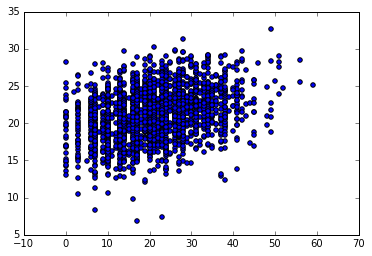

In [2088]:
predictions = cross_val_predict(regressor, X_train_away, y_train_away, cv=10)
plt.scatter(y_train_away, predictions)
plt.show()

In [2089]:
accuracy = metrics.r2_score(y_train_away, predictions)
print('Cross-Predicted Accuracy: ', accuracy)

Cross-Predicted Accuracy:  0.107568335109


In [2090]:
#Add column of ones to account for b_0
X_train_away = np.append(arr = np.ones((2188,1)).astype(int), values = X_train_away, axis = 1)
X_train_away[1]

array([  1.00000000e+00,   3.70000000e-02,  -6.21428571e+00,
         4.90000000e+01,  -9.10000000e-02,   4.58571429e+00,
        -3.50000000e+00,   3.88571429e+00,   0.00000000e+00,
         7.94285714e+00,   1.00000000e+00,  -2.56000000e-01])

In [2091]:
X_opt = X_train_away[:, [0,1,2,3,4,5,6,7,8,9,10,11]]
regressor_OLS = sm.OLS(endog = y_train_away, exog = X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     pf   R-squared:                       0.118
Model:                            OLS   Adj. R-squared:                  0.114
Method:                 Least Squares   F-statistic:                     26.52
Date:                Mon, 22 Jul 2019   Prob (F-statistic):           2.24e-52
Time:                        02:58:59   Log-Likelihood:                -7972.2
No. Observations:                2188   AIC:                         1.597e+04
Df Residuals:                    2176   BIC:                         1.604e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.9698      2.037      6.366      0.000       8.975      16.965
x1            -0.6647      4.159     -0.160      0.873      -8.821       7.492
x2             0.0419      0.040      1.045      0.296      -0.037       0.120
x3             0.1948      0.044      4.389      0.000       0.108       0.282
x4             2.8719      1.658      1.732      0.083      -0.380       6.124
x5            -0.0445      0.077     -0.580      0.562      -0.195       0.106
x6            -0.0534      0.059     -0.899      0.369      -0.170       0.063
x7             0.1198      0.047      2.523      0.012       0.027       0.213
x8            -0.4480      0.455     -0.985      0.325      -1.340       0.444
x9            -0.0512      0.031     -1.665      0.096      -0.112       0.009
x10           -0.1386      0.511     -0.271      0.786      -1.140       0.863
x11            4.8299      1.171      4.125      0.000       2.534       7.126
==============================================================================
Omnibus:                       16.352   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               16.602
Skew:                           0.213   Prob(JB):                     0.000248
Kurtosis:                       2.996   Cond. No.                         989.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [2092]:
X_opt = X_train_away[:, [0,2,3,4,5,6,7,8,9,10,11]]
regressor_OLS = sm.OLS(endog = y_train_away, exog = X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     pf   R-squared:                       0.118
Model:                            OLS   Adj. R-squared:                  0.114
Method:                 Least Squares   F-statistic:                     29.18
Date:                Mon, 22 Jul 2019   Prob (F-statistic):           4.07e-53
Time:                        02:58:59   Log-Likelihood:                -7972.2
No. Observations:                2188   AIC:                         1.597e+04
Df Residuals:                    2177   BIC:                         1.603e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.9995      2.028      6.409      0.000       9.022      16.977
x1             0.0418      0.040      1.045      0.296      -0.037       0.120
x2             0.1942      0.044      4.394      0.000       0.108       0.281
x3             2.9220      1.628      1.795      0.073      -0.271       6.115
x4            -0.0447      0.077     -0.582      0.561      -0.195       0.106
x5            -0.0522      0.059     -0.886      0.376      -0.168       0.063
x6             0.1196      0.047      2.520      0.012       0.027       0.213
x7            -0.4482      0.455     -0.986      0.324      -1.340       0.444
x8            -0.0513      0.031     -1.667      0.096      -0.112       0.009
x9            -0.1390      0.511     -0.272      0.786      -1.141       0.863
x10            4.7863      1.138      4.204      0.000       2.554       7.019
==============================================================================
Omnibus:                       16.327   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               16.579
Skew:                           0.213   Prob(JB):                     0.000251
Kurtosis:                       2.995   Cond. No.                         494.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [2093]:
X_opt = X_train_away[:, [0,2,3,4,5,6,7,9,10,11]]
regressor_OLS = sm.OLS(endog = y_train_away, exog = X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     pf   R-squared:                       0.118
Model:                            OLS   Adj. R-squared:                  0.114
Method:                 Least Squares   F-statistic:                     32.32
Date:                Mon, 22 Jul 2019   Prob (F-statistic):           1.11e-53
Time:                        02:58:59   Log-Likelihood:                -7972.7
No. Observations:                2188   AIC:                         1.597e+04
Df Residuals:                    2178   BIC:                         1.602e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.6655      2.000      6.333      0.000       8.744      16.587
x1             0.0455      0.040      1.140      0.254      -0.033       0.124
x2             0.1938      0.044      4.387      0.000       0.107       0.280
x3             2.8021      1.623      1.726      0.084      -0.382       5.986
x4            -0.0432      0.077     -0.563      0.573      -0.194       0.107
x5            -0.0515      0.059     -0.875      0.382      -0.167       0.064
x6             0.1201      0.047      2.531      0.011       0.027       0.213
x7            -0.0530      0.031     -1.725      0.085      -0.113       0.007
x8             0.0946      0.452      0.209      0.834      -0.793       0.982
x9             4.8344      1.137      4.250      0.000       2.604       7.065
==============================================================================
Omnibus:                       16.072   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               16.314
Skew:                           0.211   Prob(JB):                     0.000287
Kurtosis:                       2.995   Cond. No.                         486.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [2094]:
X_opt = X_train_away[:, [0,2,3,4,5,6,7,9,11]]
regressor_OLS = sm.OLS(endog = y_train_away, exog = X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     pf   R-squared:                       0.118
Model:                            OLS   Adj. R-squared:                  0.115
Method:                 Least Squares   F-statistic:                     36.37
Date:                Mon, 22 Jul 2019   Prob (F-statistic):           1.82e-54
Time:                        02:58:59   Log-Likelihood:                -7972.7
No. Observations:                2188   AIC:                         1.596e+04
Df Residuals:                    2179   BIC:                         1.601e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.7356      1.971      6.461      0.000       8.870      16.601
x1             0.0450      0.040      1.131      0.258      -0.033       0.123
x2             0.1938      0.044      4.387      0.000       0.107       0.280
x3             2.8049      1.623      1.728      0.084      -0.378       5.988
x4            -0.0438      0.077     -0.572      0.567      -0.194       0.106
x5            -0.0502      0.059     -0.858      0.391      -0.165       0.065
x6             0.1201      0.047      2.532      0.011       0.027       0.213
x7            -0.0527      0.031     -1.718      0.086      -0.113       0.007
x8             4.8159      1.134      4.248      0.000       2.593       7.039
==============================================================================
Omnibus:                       16.180   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               16.423
Skew:                           0.212   Prob(JB):                     0.000271
Kurtosis:                       2.996   Cond. No.                         480.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [2095]:
X_opt = X_train_away[:, [0,2,3,4,6,7,9,11]]
regressor_OLS = sm.OLS(endog = y_train_away, exog = X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     pf   R-squared:                       0.118
Model:                            OLS   Adj. R-squared:                  0.115
Method:                 Least Squares   F-statistic:                     41.53
Date:                Mon, 22 Jul 2019   Prob (F-statistic):           3.19e-55
Time:                        02:59:00   Log-Likelihood:                -7972.9
No. Observations:                2188   AIC:                         1.596e+04
Df Residuals:                    2180   BIC:                         1.601e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.7060      1.970      6.449      0.000       8.843      16.570
x1             0.0296      0.029      1.012      0.311      -0.028       0.087
x2             0.1913      0.044      4.353      0.000       0.105       0.278
x3             2.6009      1.583      1.643      0.101      -0.504       5.706
x4            -0.0610      0.055     -1.101      0.271      -0.170       0.048
x5             0.1018      0.035      2.902      0.004       0.033       0.171
x6            -0.0607      0.027     -2.225      0.026      -0.114      -0.007
x7             4.9579      1.106      4.483      0.000       2.789       7.127
==============================================================================
Omnibus:                       16.194   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               16.437
Skew:                           0.212   Prob(JB):                     0.000270
Kurtosis:                       2.997   Cond. No.                         475.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [2096]:
X_opt = X_train_away[:, [0,2,3,4,7,9,11]]
regressor_OLS = sm.OLS(endog = y_train_away, exog = X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     pf   R-squared:                       0.117
Model:                            OLS   Adj. R-squared:                  0.115
Method:                 Least Squares   F-statistic:                     48.24
Date:                Mon, 22 Jul 2019   Prob (F-statistic):           7.97e-56
Time:                        02:59:00   Log-Likelihood:                -7973.5
No. Observations:                2188   AIC:                         1.596e+04
Df Residuals:                    2181   BIC:                         1.600e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.0515      1.945      6.710      0.000       9.237      16.866
x1             0.0201      0.028      0.720      0.472      -0.035       0.075
x2             0.1847      0.044      4.242      0.000       0.099       0.270
x3             3.1104      1.514      2.054      0.040       0.141       6.080
x4             0.0843      0.031      2.696      0.007       0.023       0.146
x5            -0.0681      0.026     -2.574      0.010      -0.120      -0.016
x6             4.2711      0.913      4.676      0.000       2.480       6.062
==============================================================================
Omnibus:                       16.043   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               16.285
Skew:                           0.211   Prob(JB):                     0.000291
Kurtosis:                       2.994   Cond. No.                         465.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [2097]:
X_opt = X_train_away[:, [0,3,4,7,9,11]]
regressor_OLS = sm.OLS(endog = y_train_away, exog = X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     pf   R-squared:                       0.117
Model:                            OLS   Adj. R-squared:                  0.115
Method:                 Least Squares   F-statistic:                     57.80
Date:                Mon, 22 Jul 2019   Prob (F-statistic):           1.28e-56
Time:                        02:59:00   Log-Likelihood:                -7973.7
No. Observations:                2188   AIC:                         1.596e+04
Df Residuals:                    2182   BIC:                         1.599e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.7597      1.902      6.708      0.000       9.030      16.490
x1             0.1896      0.043      4.410      0.000       0.105       0.274
x2             3.3055      1.489      2.219      0.027       0.385       6.226
x3             0.0821      0.031      2.639      0.008       0.021       0.143
x4            -0.0700      0.026     -2.659      0.008      -0.122      -0.018
x5             4.2511      0.913      4.657      0.000       2.461       6.041
==============================================================================
Omnibus:                       15.804   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               16.042
Skew:                           0.210   Prob(JB):                     0.000328
Kurtosis:                       2.990   Cond. No.                         457.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [2098]:
X_opt = X_train_away[:, [0,3,7,9,11]]
regressor_OLS = sm.OLS(endog = y_train_away, exog = X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     pf   R-squared:                       0.115
Model:                            OLS   Adj. R-squared:                  0.113
Method:                 Least Squares   F-statistic:                     70.89
Date:                Mon, 22 Jul 2019   Prob (F-statistic):           1.63e-56
Time:                        02:59:00   Log-Likelihood:                -7976.2
No. Observations:                2188   AIC:                         1.596e+04
Df Residuals:                    2183   BIC:                         1.599e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.9663      1.870      6.399      0.000       8.299      15.633
x1             0.2065      0.042      4.875      0.000       0.123       0.290
x2             0.1052      0.029      3.586      0.000       0.048       0.163
x3            -0.0634      0.026     -2.424      0.015      -0.115      -0.012
x4             5.2787      0.787      6.704      0.000       3.735       6.823
==============================================================================
Omnibus:                       14.841   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               15.055
Skew:                           0.203   Prob(JB):                     0.000538
Kurtosis:                       2.984   Cond. No.                         445.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [2099]:
X_opt = X_train_away[:, [0,3,7,11]]
regressor_OLS = sm.OLS(endog = y_train_away, exog = X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     pf   R-squared:                       0.113
Model:                            OLS   Adj. R-squared:                  0.111
Method:                 Least Squares   F-statistic:                     92.35
Date:                Mon, 22 Jul 2019   Prob (F-statistic):           2.86e-56
Time:                        02:59:01   Log-Likelihood:                -7979.1
No. Observations:                2188   AIC:                         1.597e+04
Df Residuals:                    2184   BIC:                         1.599e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.9202      1.872      6.368      0.000       8.249      15.591
x1             0.1973      0.042      4.670      0.000       0.114       0.280
x2             0.1095      0.029      3.733      0.000       0.052       0.167
x3             5.1112      0.785      6.509      0.000       3.571       6.651
==============================================================================
Omnibus:                       15.811   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               16.068
Skew:                           0.210   Prob(JB):                     0.000324
Kurtosis:                       2.977   Cond. No.                         439.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

$y_{away} = 0.195x_{ptsMatchup} + 2.566x_{offDvoaMatchup} + 0.099x_{passMatchup} + 4.957x_{totalDvoaMatchup} + 12.042$

In [2100]:
# Optimal model using alpha < 0.05 significance level ^
X_test_away.shape

(548, 11)

In [2101]:
# Now use this model to make predictions on the test set
X_test_away = np.append(arr = np.ones((548,1)).astype(int), values = X_test_away, axis = 1)
X_test_away = X_test_away[:, [0,3,7,11]]
regressor = LinearRegression()
regressor.fit(X_opt, y_train_away)
y_pred_away = regressor.predict(X_test_away)

In [2102]:
print(mean_squared_error(y_test_away, y_pred_away))

99.405905605


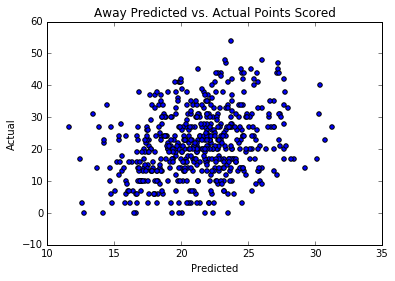

In [2103]:
plt.scatter(y_pred_away, y_test_away)
plt.title("Away Predicted vs. Actual Points Scored")
plt.xlabel('Predicted')
plt.ylabel("Actual")
plt.show()

In [2104]:
from scipy.stats import pearsonr
pearsonr(y_test_away,y_pred_away)

(array([ 0.3059694]), array([  2.43319862e-13]))

We can see a pretty clear positive correlation between our predicted and actual values for away teams. The pearson correlation comes out as .349, with an extremely  low p-value

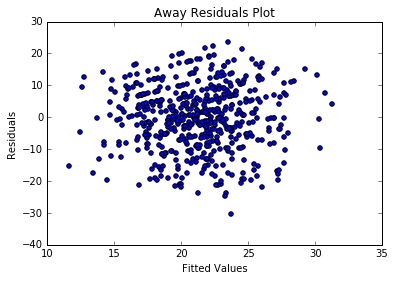

In [2105]:
residuals = y_pred_away - y_test_away
plt.scatter(y_pred_away, residuals)
plt.title("Away Residuals Plot")
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

There is no clear pattern among the fitted vs. residuals plot, so there are no issues. One thing to note is that the residuals tend to be a bit more negative than positive. One reason for this might be that it is much easier for an NFL team to not play well and heavily underperform than it is for a team to play so well that they outperform their prediction by 20+ points.

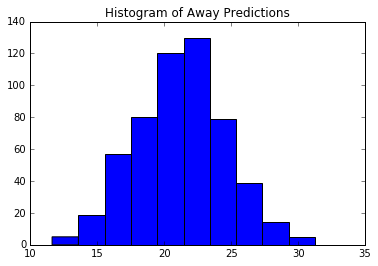

In [2106]:
plt.hist(y_pred_away)
plt.title("Histogram of Away Predictions")
plt.show()

The histogram of our predictions is clearly normal, and centered around the 20-22 range. There may be one or two predictions above 30, but nothing out of the ordinary here.

In [2107]:
import statsmodels.api as sm
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
%matplotlib inline 

In [2108]:
# fig, ax = plt.subplots(figsize=(20,20))
# fig = sm.graphics.influence_plot(regressor_OLS, criterion="cooks",size=48,ax=ax)

There doesn't seem to be anything out of the ordinary with the influence plot, so we shouldn't need to remove any data from the awayMatchup table. Let's move on to the home table.

In [2109]:
# Now repeat the process for homeMatchup table:
X_train_home, X_test_home, y_train_home, y_test_home = train_test_split(homeMatchup.iloc[:,:-1],homeMatchup.iloc[:,-1:], test_size=0.2,random_state=155)

for var in cat_cols:
    number = LabelEncoder()
    X_train_home[var] = number.fit_transform(X_train_home[var].astype('str'))

for var in cat_cols:
    number = LabelEncoder()
    X_test_home[var] = number.fit_transform(X_test_home[var].astype('str'))
    
features=list(set(list(X_train_home.columns))-set(ID_col)-set(target_col)-set(other_col))

X_train_home = X_train_home[list(features)]
X_test_home= X_test_home[list(features)]

X_train_home = X_train_home[['stDvoa', 'runMatchup', 'ptsMatchup', 'offDvoaMatchup', 'offMatchup',
       'ovrMatchup', 'passMatchup', 'surface', 'pblkMatchup', 'roof',
       'totalDvoaMatchup']]

X_test_home = X_test_home[['stDvoa', 'runMatchup', 'ptsMatchup', 'offDvoaMatchup', 'offMatchup',
       'ovrMatchup', 'passMatchup', 'surface', 'pblkMatchup', 'roof',
       'totalDvoaMatchup']]

In [2110]:
X_train_home.head()

,stDvoa,runMatchup,ptsMatchup,offDvoaMatchup,offMatchup,ovrMatchup,passMatchup,surface,pblkMatchup,roof,totalDvoaMatchup
547,0.004,-2.985714,49.428571,0.082,8.928571,6.671429,10.885714,1,7.542857,0,0.108
2082,0.019,-3.800000,45.714286,0.183,9.942857,3.500000,12.014286,0,10.957143,1,0.256
1463,0.098,-14.542857,36.857143,-0.352,-10.142857,-11.914286,-16.700000,0,4.800000,1,-0.187
297,0.031,-6.214286,46.714286,0.120,6.085714,13.128571,9.028571,1,16.385714,1,0.497
1092,0.016,8.028571,51.285714,0.626,8.042857,-0.400000,-3.585714,1,1.971429,0,0.861


In [2111]:
regressor = LinearRegression()
regressor.fit(X_train_home, y_train_home)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [2112]:
# Perform 10-fold cross validation
scores = cross_val_score(regressor, X_train_home, y_train_home, cv=10)
print('Cross-validated scores: ', scores)

Cross-validated scores:  [ 0.06563876  0.09009683  0.12507486  0.13478519  0.13340275  0.04107027
  0.10632789  0.06829002  0.18300692  0.07159431]


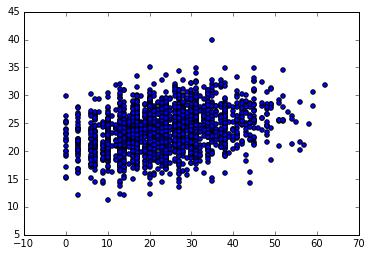

In [2113]:
predictions = cross_val_predict(regressor, X_train_home, y_train_home, cv=10)
plt.scatter(y_train_home, predictions)
plt.show()

In [2114]:
accuracy = metrics.r2_score(y_train_home, predictions)
print('Cross-Predicted Accuracy: ', accuracy)

Cross-Predicted Accuracy:  0.104659259006


In [2115]:
X_train_home.shape

(2188, 11)

In [2116]:
#Add column of ones to account for b_0
X_train_home = np.append(arr = np.ones((2188,1)).astype(int), values = X_train_home, axis = 1)
X_train_home[1]

array([  1.00000000e+00,   1.90000000e-02,  -3.80000000e+00,
         4.57142857e+01,   1.83000000e-01,   9.94285714e+00,
         3.50000000e+00,   1.20142857e+01,   0.00000000e+00,
         1.09571429e+01,   1.00000000e+00,   2.56000000e-01])

In [2117]:
X_opt = X_train_home[:, [0,1,2,3,4,5,6,7,8,9,10,11]]
regressor_OLS = sm.OLS(endog = y_train_home, exog = X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     pf   R-squared:                       0.116
Model:                            OLS   Adj. R-squared:                  0.111
Method:                 Least Squares   F-statistic:                     25.91
Date:                Mon, 22 Jul 2019   Prob (F-statistic):           3.90e-51
Time:                        02:59:06   Log-Likelihood:                -8127.1
No. Observations:                2188   AIC:                         1.628e+04
Df Residuals:                    2176   BIC:                         1.635e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.3185      2.217      6.007      0.000       8.971      17.666
x1             6.9091      4.446      1.554      0.120      -1.809      15.627
x2             0.0098      0.042      0.232      0.817      -0.073       0.092
x3             0.2345      0.048      4.925      0.000       0.141       0.328
x4             4.4827      1.786      2.510      0.012       0.980       7.986
x5            -0.0203      0.083     -0.245      0.806      -0.183       0.142
x6            -0.0062      0.064     -0.096      0.924      -0.133       0.120
x7             0.0514      0.050      1.029      0.304      -0.047       0.149
x8             0.8077      0.489      1.651      0.099      -0.152       1.767
x9             0.0666      0.034      1.962      0.050    1.98e-05       0.133
x10           -1.3161      0.546     -2.408      0.016      -2.388      -0.244
x11            3.2896      1.297      2.537      0.011       0.746       5.833
==============================================================================
Omnibus:                       27.326   Durbin-Watson:                   2.118
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               28.046
Skew:                           0.268   Prob(JB):                     8.13e-07
Kurtosis:                       3.141   Cond. No.                         981.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [2118]:
X_opt = X_train_home[:, [0,1,2,3,4,6,7,8,9,10,11]]
regressor_OLS = sm.OLS(endog = y_train_home, exog = X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     pf   R-squared:                       0.116
Model:                            OLS   Adj. R-squared:                  0.112
Method:                 Least Squares   F-statistic:                     28.51
Date:                Mon, 22 Jul 2019   Prob (F-statistic):           7.30e-52
Time:                        02:59:06   Log-Likelihood:                -8127.1
No. Observations:                2188   AIC:                         1.628e+04
Df Residuals:                    2177   BIC:                         1.634e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.2789      2.211      6.007      0.000       8.944      17.614
x1             6.9299      4.444      1.559      0.119      -1.785      15.645
x2             0.0026      0.030      0.087      0.931      -0.057       0.062
x3             0.2337      0.047      4.921      0.000       0.141       0.327
x4             4.3705      1.726      2.532      0.011       0.985       7.756
x5            -0.0111      0.061     -0.182      0.856      -0.131       0.109
x6             0.0431      0.037      1.173      0.241      -0.029       0.115
x7             0.8155      0.488      1.671      0.095      -0.142       1.773
x8             0.0628      0.030      2.081      0.038       0.004       0.122
x9            -1.3068      0.545     -2.398      0.017      -2.376      -0.238
x10            3.3604      1.264      2.658      0.008       0.882       5.839
==============================================================================
Omnibus:                       27.368   Durbin-Watson:                   2.118
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               28.091
Skew:                           0.268   Prob(JB):                     7.95e-07
Kurtosis:                       3.141   Cond. No.                         975.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [2119]:
X_opt = X_train_home[:, [0,2,3,4,6,7,8,9,10,11]]
regressor_OLS = sm.OLS(endog = y_train_home, exog = X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     pf   R-squared:                       0.115
Model:                            OLS   Adj. R-squared:                  0.111
Method:                 Least Squares   F-statistic:                     31.39
Date:                Mon, 22 Jul 2019   Prob (F-statistic):           4.12e-52
Time:                        02:59:07   Log-Likelihood:                -8128.4
No. Observations:                2188   AIC:                         1.628e+04
Df Residuals:                    2178   BIC:                         1.633e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.8602      2.195      5.859      0.000       8.556      17.165
x1             0.0054      0.030      0.176      0.860      -0.054       0.065
x2             0.2407      0.047      5.089      0.000       0.148       0.333
x3             3.9604      1.707      2.321      0.020       0.613       7.307
x4            -0.0270      0.060     -0.448      0.654      -0.145       0.091
x5             0.0454      0.037      1.234      0.217      -0.027       0.117
x6             0.9361      0.482      1.942      0.052      -0.009       1.882
x7             0.0632      0.030      2.094      0.036       0.004       0.122
x8            -1.2282      0.543     -2.263      0.024      -2.293      -0.164
x9             3.8478      1.225      3.141      0.002       1.445       6.251
==============================================================================
Omnibus:                       28.267   Durbin-Watson:                   2.118
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               29.033
Skew:                           0.274   Prob(JB):                     4.96e-07
Kurtosis:                       3.131   Cond. No.                         489.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [2120]:
X_opt = X_train_home[:, [0,2,3,4,7,8,9,10,11]]
regressor_OLS = sm.OLS(endog = y_train_home, exog = X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     pf   R-squared:                       0.115
Model:                            OLS   Adj. R-squared:                  0.111
Method:                 Least Squares   F-statistic:                     35.30
Date:                Mon, 22 Jul 2019   Prob (F-statistic):           7.38e-53
Time:                        02:59:07   Log-Likelihood:                -8128.5
No. Observations:                2188   AIC:                         1.627e+04
Df Residuals:                    2179   BIC:                         1.633e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.0469      2.155      6.055      0.000       8.821      17.272
x1             0.0012      0.029      0.040      0.968      -0.056       0.058
x2             0.2371      0.047      5.088      0.000       0.146       0.329
x3             4.2177      1.607      2.625      0.009       1.067       7.368
x4             0.0382      0.033      1.154      0.248      -0.027       0.103
x5             0.9242      0.481      1.920      0.055      -0.020       1.868
x6             0.0595      0.029      2.050      0.040       0.003       0.116
x7            -1.2251      0.543     -2.257      0.024      -2.289      -0.161
x8             3.5301      0.998      3.536      0.000       1.572       5.488
==============================================================================
Omnibus:                       28.120   Durbin-Watson:                   2.118
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               28.875
Skew:                           0.274   Prob(JB):                     5.37e-07
Kurtosis:                       3.129   Cond. No.                         478.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [2121]:
X_opt = X_train_home[:, [0,3,4,7,8,9,10,11]]
regressor_OLS = sm.OLS(endog = y_train_home, exog = X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     pf   R-squared:                       0.115
Model:                            OLS   Adj. R-squared:                  0.112
Method:                 Least Squares   F-statistic:                     40.36
Date:                Mon, 22 Jul 2019   Prob (F-statistic):           1.12e-53
Time:                        02:59:07   Log-Likelihood:                -8128.5
No. Observations:                2188   AIC:                         1.627e+04
Df Residuals:                    2180   BIC:                         1.632e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.0279      2.102      6.197      0.000       8.905      17.150
x1             0.2375      0.046      5.183      0.000       0.148       0.327
x2             4.2288      1.582      2.672      0.008       1.126       7.332
x3             0.0381      0.033      1.157      0.247      -0.026       0.103
x4             0.9239      0.481      1.920      0.055      -0.020       1.867
x5             0.0594      0.029      2.054      0.040       0.003       0.116
x6            -1.2257      0.542     -2.260      0.024      -2.289      -0.162
x7             3.5283      0.997      3.538      0.000       1.573       5.484
==============================================================================
Omnibus:                       28.162   Durbin-Watson:                   2.118
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               28.920
Skew:                           0.274   Prob(JB):                     5.25e-07
Kurtosis:                       3.129   Cond. No.                         467.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [2122]:
X_opt = X_train_home[:, [0,3,4,8,9,10,11]]
regressor_OLS = sm.OLS(endog = y_train_home, exog = X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     pf   R-squared:                       0.114
Model:                            OLS   Adj. R-squared:                  0.112
Method:                 Least Squares   F-statistic:                     46.85
Date:                Mon, 22 Jul 2019   Prob (F-statistic):           3.01e-54
Time:                        02:59:07   Log-Likelihood:                -8129.1
No. Observations:                2188   AIC:                         1.627e+04
Df Residuals:                    2181   BIC:                         1.631e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.1262      1.952      6.211      0.000       8.297      15.955
x1             0.2601      0.041      6.281      0.000       0.179       0.341
x2             4.7441      1.519      3.124      0.002       1.766       7.722
x3             0.9454      0.481      1.966      0.049       0.003       1.888
x4             0.0565      0.029      1.960      0.050   -2.44e-05       0.113
x5            -1.2435      0.542     -2.293      0.022      -2.307      -0.180
x6             3.5103      0.997      3.520      0.000       1.555       5.466
==============================================================================
Omnibus:                       27.542   Durbin-Watson:                   2.120
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               28.252
Skew:                           0.272   Prob(JB):                     7.33e-07
Kurtosis:                       3.122   Cond. No.                         446.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [2123]:
X_opt = X_train_home[:, [0,3,4,9,10,11]]
regressor_OLS = sm.OLS(endog = y_train_home, exog = X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     pf   R-squared:                       0.113
Model:                            OLS   Adj. R-squared:                  0.111
Method:                 Least Squares   F-statistic:                     55.38
Date:                Mon, 22 Jul 2019   Prob (F-statistic):           2.57e-54
Time:                        02:59:08   Log-Likelihood:                -8131.1
No. Observations:                2188   AIC:                         1.627e+04
Df Residuals:                    2182   BIC:                         1.631e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.8666      1.917      6.711      0.000       9.107      16.626
x1             0.2605      0.041      6.286      0.000       0.179       0.342
x2             4.7055      1.519      3.097      0.002       1.726       7.685
x3             0.0595      0.029      2.068      0.039       0.003       0.116
x4            -1.7276      0.483     -3.574      0.000      -2.676      -0.780
x5             3.5752      0.997      3.585      0.000       1.620       5.531
==============================================================================
Omnibus:                       26.969   Durbin-Watson:                   2.119
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               27.641
Skew:                           0.269   Prob(JB):                     9.95e-07
Kurtosis:                       3.119   Cond. No.                         440.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [2124]:
X_test_home.shape

(548, 11)

In [2125]:
# Now use this model to make predictions on the test set
X_test_home = np.append(arr = np.ones((548,1)).astype(int), values = X_test_home, axis = 1)
X_test_home = X_test_home[:, [0,3,4,9,10,11]]
regressor = LinearRegression()
regressor.fit(X_opt, y_train_home)
y_pred_home = regressor.predict(X_test_home)

In [2126]:
print(mean_squared_error(y_test_home, y_pred_home))

101.289218848


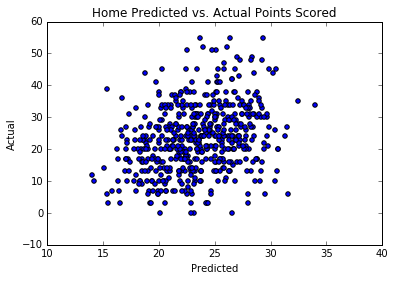

In [2127]:
plt.scatter(y_pred_home, y_test_home)
plt.title("Home Predicted vs. Actual Points Scored")
plt.xlabel('Predicted')
plt.ylabel("Actual")
plt.show()

In [2128]:
from scipy.stats import pearsonr
pearsonr(y_test_home,y_pred_home)

(array([ 0.2994122]), array([  8.19152977e-13]))

We can see a pretty clear positive correlation between our predicted and actual values for home teams. The pearson correlation comes out as .311, with an extremely  low p-value

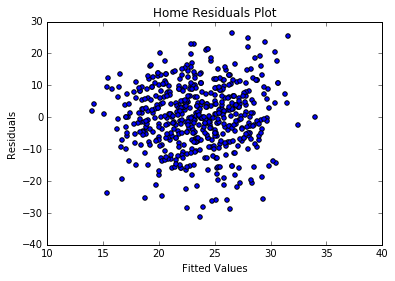

In [2129]:
residuals = y_pred_home - y_test_home
plt.scatter(y_pred_home, residuals)
plt.title('Home Residuals Plot')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

There is no clear pattern among the fitted vs. residuals plot, so there are no issues. We may want to explore the three points to the left.

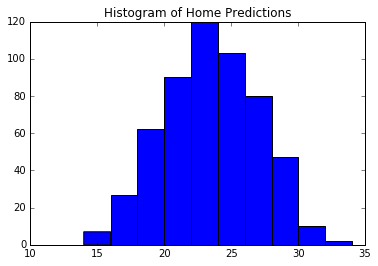

In [2130]:
plt.hist(y_pred_home)
plt.title("Histogram of Home Predictions")
plt.show()

In [2131]:
# fig, ax = plt.subplots(figsize=(20,20))
# fig = sm.graphics.influence_plot(regressor_OLS, criterion="cooks",size=48,ax=ax)

There doesn't seem to be anything out of the ordinary with the influence plot, so we shouldn't need to remove any data from the homeMatchup table. Now let's put it all together and make predictions for total scores between home and away teams.

In [2132]:
y_test_away = y_test_away.reset_index()
y_test_away = y_test_away[['pf']]
y_test_home = y_test_home.reset_index()
y_test_home = y_test_home[['pf']]

In [2133]:
testDf = pd.DataFrame(X_test_away)
testDf['awayScore'] = y_test_away
testDf['awayPrediction'] = y_pred_away
testDf2 = pd.DataFrame(X_test_home)
testDf2['homeScore'] = y_test_home
testDf2['homePrediction'] = y_pred_home

In [2134]:
testDf = testDf.rename(index=int, columns = {1:'ptsMatchup',2:'passMatchup',3:'totalDvoaMatchup'})
testDf = testDf.drop(0,axis=1)
testDf.head()

,ptsMatchup,passMatchup,totalDvoaMatchup,awayScore,awayPrediction
0,41.142857,-2.000000,-0.161,22,18.994979
1,41.857143,3.428571,-0.133,21,19.873376
2,43.857143,5.657143,-0.103,7,20.665275
3,42.285714,0.985714,-0.215,21,19.271343
4,25.000000,-10.471429,-0.574,0,12.771875


In [2135]:
testDf2.head()

,0,1,2,3,4,5,homeScore,homePrediction
0,1.0,46.714286,-0.026,3.042857,0.0,0.161,17,25.669160
1,1.0,47.142857,0.096,15.714286,0.0,0.133,49,27.008916
2,1.0,48.857143,0.026,11.500000,1.0,0.103,21,25.040350
3,1.0,50.714286,0.024,22.428571,1.0,0.215,42,26.565540
4,1.0,41.142857,0.234,4.314286,1.0,0.574,27,25.265930


In [2136]:
testDf2 = testDf2.rename(index=int, columns = {1:'ptsMatchup',2:'offDvoaMatchup', 3: 'pblkMatchup',4:'roof',5:'totalDvoaMatchup'})
testDf2 = testDf2.drop(0,axis=1)
testDf2.head()

,ptsMatchup,offDvoaMatchup,pblkMatchup,roof,totalDvoaMatchup,homeScore,homePrediction
0,46.714286,-0.026,3.042857,0.0,0.161,17,25.669160
1,47.142857,0.096,15.714286,0.0,0.133,49,27.008916
2,48.857143,0.026,11.500000,1.0,0.103,21,25.040350
3,50.714286,0.024,22.428571,1.0,0.215,42,26.565540
4,41.142857,0.234,4.314286,1.0,0.574,27,25.265930


In [2137]:
# Join awayMatchup table with away predictions and do same for home team. make sure to take out surface column
# since it is now binary, and wasn't in theoriginal table

colsAway = list(testDf.columns)
colsAway.pop(-1)
colsAway.pop(-1)
# colsAway
colsHome = list(testDf2.columns)
colsHome.pop(-1)
colsHome.pop(-1)
colsHome.pop(3)
# colsHome
# # cols.pop(7)
# # cols.pop(7)

'roof'

In [2138]:
awayPredDf = awayMatchup.merge(testDf, on=colsAway)
homePredDf = homeMatchup.merge(testDf2, on=colsHome)

In [2139]:
awayHomeMerge = awayPredDf.merge(homePredDf, on=['gameId','date','season','week'])
#awayHomeMerge.columns

In [2140]:
awayHomeMerge = awayHomeMerge[['gameId', 'date', 'season', 'week','awayPrediction', 'homePrediction']]
awayHomeMerge.head()

,gameId,date,season,week,awayPrediction,homePrediction
0,201711050sfo,2017-11-05,2017,9,21.811706,22.597833
1,201701010ram,2017-01-01,2016,17,24.567092,19.897253
2,201610160sea,2016-10-16,2016,6,20.550990,24.322534
3,201812090gnb,2018-12-09,2018,14,21.737458,26.217291
4,201801060ram,2018-01-06,2017,18,20.067344,24.929437


In [2141]:
finalDf = gameTable.merge(awayHomeMerge, on=['gameId', 'date'])
finalDf['totalPrediction'] = finalDf['awayPrediction'] + finalDf['homePrediction']
#finalDf.columns

In [2142]:
finalDf = finalDf[['gameId', 'date', 'season', 'week', 'awayTeam', 'awayPrediction', 'awayScore',
                   'homeTeam','homePrediction', 'homeScore', 'overUnder', 'result', 'totalPrediction', 'totalScore']]

In [2143]:
finalDf.head()

,gameId,date,season,week,awayTeam,awayPrediction,awayScore,homeTeam,homePrediction,homeScore,overUnder,result,totalPrediction,totalScore
0,200911220ram,2009-11-22,2009,11,Arizona Cardinals,27.833744,21,Los Angeles Rams,19.697687,13,47.0,under,47.531431,34
1,201210040ram,2012-10-04,2012,5,Arizona Cardinals,20.587708,3,Los Angeles Rams,18.982238,17,38.0,under,39.569946,20
2,200710210was,2007-10-21,2007,7,Arizona Cardinals,19.113384,19,Washington Redskins,24.287847,21,36.0,over,43.401231,40
3,201211180atl,2012-11-18,2012,11,Arizona Cardinals,17.487101,19,Atlanta Falcons,25.346060,23,44.0,under,42.833161,42
4,201510180pit,2015-10-18,2015,6,Arizona Cardinals,25.762754,13,Pittsburgh Steelers,22.571184,25,45.0,under,48.333938,38


In [2144]:
# What happens when our predictions are 5+ points less than the overUnder value?
undersDf = finalDf[finalDf['totalPrediction'] <= finalDf['overUnder'] - 5]
undersDf['result'].value_counts()

under    9
over     7
Name: result, dtype: int64

In [2145]:
# What happens when our predictions are 3+ points less than the overUnder value?
undersDf = finalDf[finalDf['totalPrediction'] <= finalDf['overUnder'] - 3]
undersDf['result'].value_counts()

under    34
over     22
Name: result, dtype: int64

In [2146]:
# What happens when our predictions are 1+ point less than the overUnder value?
undersDf = finalDf[finalDf['totalPrediction'] <= finalDf['overUnder'] - 1]
undersDf['result'].value_counts()

under    82
over     74
Name: result, dtype: int64

In [2147]:
# What happens when our predictions are 5+ points more than the overUnder value?
oversDf = finalDf[finalDf['totalPrediction'] >= finalDf['overUnder'] + 5]
oversDf['result'].value_counts()

over     23
under    12
Name: result, dtype: int64

In [2148]:
# What happens when our predictions are 3+ points more than the overUnder value?
oversDf = finalDf[finalDf['totalPrediction'] >= finalDf['overUnder'] + 3]
oversDf['result'].value_counts()

over     61
under    43
Name: result, dtype: int64

In [2149]:
# What happens when our predictions are 1+ point more than the overUnder value?
oversDf = finalDf[finalDf['totalPrediction'] >= finalDf['overUnder'] + 1]
oversDf['result'].value_counts()

over     126
under    118
push       4
Name: result, dtype: int64

We observe a 21-11 win/loss rate (65.625% win) when using the predictions that are 5+ points over the overUnder value. We get a 14-9 win/loss rate (60.87% win) when using the predictions that are 5+ points under the overUnder value. Both of these win rates exceed the needed win rate of 52.4% to beat the sports books.

In [2150]:
oversDf = finalDf[finalDf['totalPrediction'] >= finalDf['overUnder'] + 5]
oversDf

,gameId,date,season,week,awayTeam,awayPrediction,awayScore,homeTeam,homePrediction,homeScore,overUnder,result,totalPrediction,totalScore
2,200710210was,2007-10-21,2007,7,Arizona Cardinals,19.113384,19,Washington Redskins,24.287847,21,36.0,over,43.401231,40
5,201711050sfo,2017-11-05,2017,9,Arizona Cardinals,21.811706,20,San Francisco 49ers,22.597833,10,39.0,under,44.409539,30
6,201701010ram,2017-01-01,2016,17,Arizona Cardinals,24.567092,44,Los Angeles Rams,19.897253,6,39.0,over,44.464345,50
9,201509270dal,2015-09-27,2015,3,Atlanta Falcons,21.577996,39,Dallas Cowboys,28.158134,28,43.5,over,49.736130,67
23,201409210cle,2014-09-21,2014,3,Baltimore Ravens,21.908211,23,Cleveland Browns,25.121282,21,41.5,over,47.029493,44
28,200809290pit,2008-09-29,2008,4,Baltimore Ravens,21.629474,20,Pittsburgh Steelers,18.529748,23,34.5,over,40.159222,43
29,200901100oti,2009-01-10,2008,19,Baltimore Ravens,20.888234,13,Tennessee Titans,19.396600,10,33.5,under,40.284834,23
31,200710070sfo,2007-10-07,2007,5,Baltimore Ravens,23.053281,9,San Francisco 49ers,16.462583,7,34.5,under,39.515864,16
80,201112250gnb,2011-12-25,2011,16,Chicago Bears,19.115430,21,Green Bay Packers,28.223694,35,42.0,over,47.339124,56
88,201201010min,2012-01-01,2011,17,Chicago Bears,25.152117,17,Minnesota Vikings,23.746850,13,42.0,under,48.898966,30


In [2151]:
len(oversDf)

35